In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mrs_denoising.denoising import sure_hard, sure_svt
from mrs_denoising.utils import lsvd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Utility functions

In [9]:
def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

## Create noiseless and noisy synthetic data

Matches data used in explicit rank = 3 simulations

Text(0.0, 0.64, 'b')

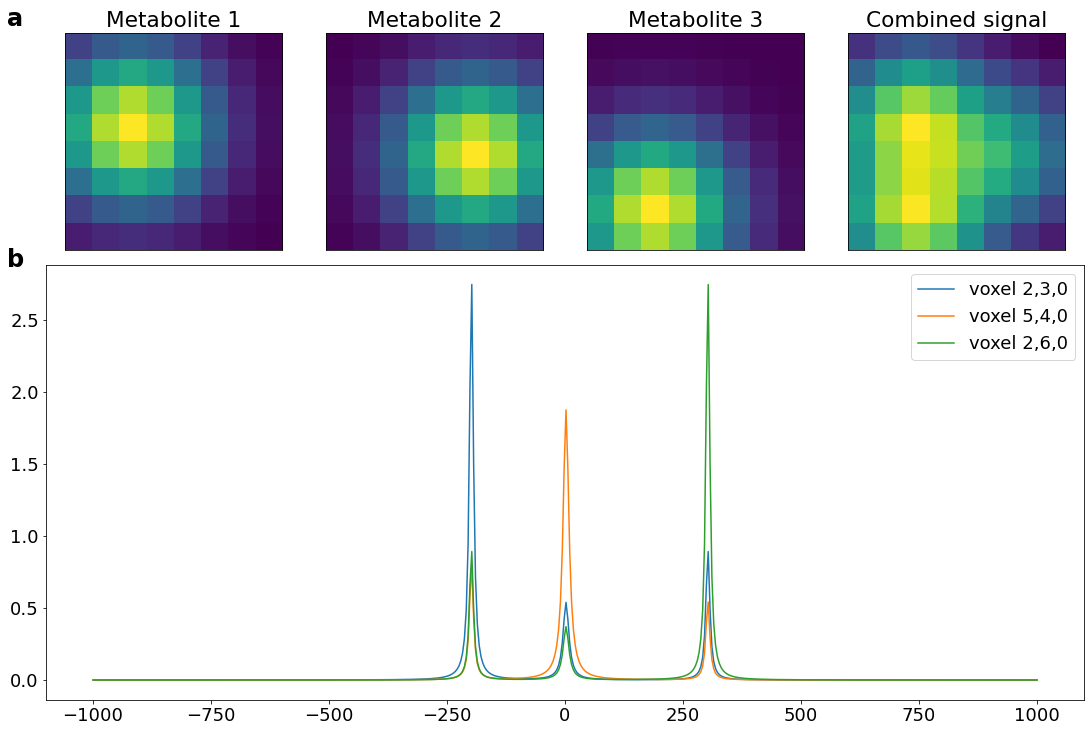

In [10]:
peak_frequencies = [-200, 0, 300]
peak_amps = [1, 1, 1]
peak_lw = [10, 15, 10]
centre_X = [2, 5, 2]
centre_Y = [3, 4, 6]

Nt = 512
bandwidth = 2000
dt = 1 / bandwidth
time_axis = dt * np.arange(0, Nt)

xx, yy, zz = np.arange(0,8), np.arange(0,8), np.arange(0,1)
X, Y, Z = np.meshgrid(xx, yy, zz)

def peak(x, c, omega, alpha, phi=0.0):
    return c * np.exp((alpha + 1j * 2 * np.pi * omega) * x) * np.exp(1j * phi)

sigma=2
noiseless = np.zeros(X.shape + (Nt,),dtype=complex)
weights = []
for pdx in range(3):
    gauss_weight = np.exp( -((X-centre_X[pdx])**2 + (Y-centre_Y[pdx])**2) / (2.*sigma**2) )
    weights.append(gauss_weight)

    fid = peak(time_axis, peak_amps[pdx], peak_frequencies[pdx], -np.pi * peak_lw[pdx])

    noiseless += gauss_weight[:,:,:,np.newaxis] * fid

# Plotting
plt.rcParams.update({'font.size': 18})
weights = np.moveaxis(np.asarray(weights),0,-1)

def no_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax1.matshow(weights[:,:,0,0])
ax2.matshow(weights[:,:,0,1])
ax3.matshow(weights[:,:,0,2])
ax4.matshow(np.mean(np.abs(noiseless),axis=3))
ax1.set_title('Metabolite 1')
ax2.set_title('Metabolite 2')
ax3.set_title('Metabolite 3')
ax4.set_title('Combined signal')
no_ticks(ax1)
no_ticks(ax2)
no_ticks(ax3)
no_ticks(ax4)

ax_big = fig.add_subplot(gs[1:, :])

freq_axis = np.linspace(-bandwidth/2, bandwidth/2, Nt)
ax_big.plot(freq_axis, FID2Spec(noiseless[3, 2, 0, :]).real, label='voxel 2,3,0')
ax_big.plot(freq_axis, FID2Spec(noiseless[4, 5, 0, :]).real, label='voxel 5,4,0')
ax_big.plot(freq_axis, FID2Spec(noiseless[6, 2, 0, :]).real, label='voxel 2,6,0')
ax_big.legend()

fig.text(0.00, 0.975,'a',fontweight='bold',fontsize=24)
fig.text(0.00, 0.64,'b',fontweight='bold',fontsize=24)

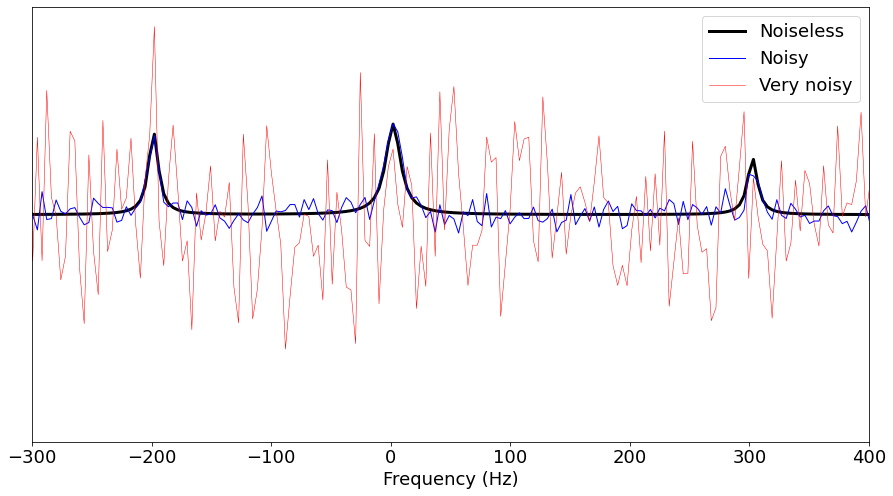

In [56]:
noisy_data = []
rng = np.random.default_rng()
sd_noisy = np.logspace(-2,0,6)
for sd in sd_noisy:
    noisy_data.append(noiseless + sd * rng.standard_normal(size=noiseless.shape) + sd * 1j * rng.standard_normal(size=noiseless.shape))

freq_axis = np.linspace(-bandwidth/2, bandwidth/2, Nt)
fig = plt.figure(figsize=(15,8))
plt.plot(freq_axis, FID2Spec(noiseless[4,4,0,:]).real,'k', linewidth=3, label='Noiseless')
plt.plot(freq_axis, FID2Spec(noisy_data[3][4,4,0,:]).real,'b', linewidth=1, label='Noisy')
plt.plot(freq_axis, FID2Spec(noisy_data[-1][4,4,0,:]).real,'r', linewidth=0.5, label='Very noisy')
plt.xlim([-300, 400])
plt.yticks([])
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

## Thresholding functions

In [110]:
def svt(data, threshold):
    U, S, V = lsvd(data.reshape(-1, data.shape[-1]))
    S = np.diag(S)

    S_scaled = np.diag(np.maximum(S-threshold, 0))
    
    return (U @ S_scaled @ V.conj().T).reshape(data.shape)

def svht(data, threshold):
    U, S, V = lsvd(data.reshape(-1, data.shape[-1]))
    S = np.diag(S)

    S_scaled = np.diag([s if s > threshold else 0 for s in S])
    return (U @ S_scaled @ V.conj().T).reshape(data.shape)

## SURE functions

In [100]:
def div_SVT(lam, S, Nx, Nt):
    z = (2 * np.abs(Nx - Nt) + 1)\
        * np.sum(np.maximum(1 - lam / S, 0))\
        + np.sum(S > lam)

    ss = np.subtract.outer(S**2, S**2)
    ss = ss[~np.eye(S.shape[0], dtype=bool)].reshape(S.shape[0], -1)
    z += np.sum(4 * S * np.maximum(S - lam, 0) / ss.T)

    return z

def SURE_SVT(lam, S, v, Nx, Nt):
    return -2 * Nx * Nt * v\
        + np.sum(np.minimum(S**2, lam**2))\
        + 2 * v * div_SVT(lam, S, Nx, Nt)

def div_HARD(r, S, Nx, Nt):
    z = (Nx + Nt) * r - r**2
    for idx in range(r):
        for jdx in range(r, S.size):
            z += 2*S[jdx]**2 / (S[idx]**2 - S[jdx]**2)
    return z

def SURE_SVHT(r, S, v, Nx, Nt):
    return -2 * Nx * Nt * v \
           + np.sum(S[r:]**2) \
           + 4 * v * div_HARD(r, S, Nx, Nt)

### Calculate range of thresholds that are sensible based on maximum singular value of noiseless data

In [57]:
_, S, _ = lsvd(noiseless.reshape(-1, noiseless.shape[-1]))
threshold = np.logspace(-3, np.log10(np.max(S)+1), 20)
threshold

array([1.00000000e-03, 1.71414998e-03, 2.93831017e-03, 5.03670432e-03,
       8.63366663e-03, 1.47993995e-02, 2.53683904e-02, 4.34852261e-02,
       7.45401996e-02, 1.27773082e-01, 2.19022226e-01, 3.75436945e-01,
       6.43555234e-01, 1.10315019e+00, 1.89096489e+00, 3.24139743e+00,
       5.55624135e+00, 9.52423102e+00, 1.63259604e+01, 2.79851448e+01])

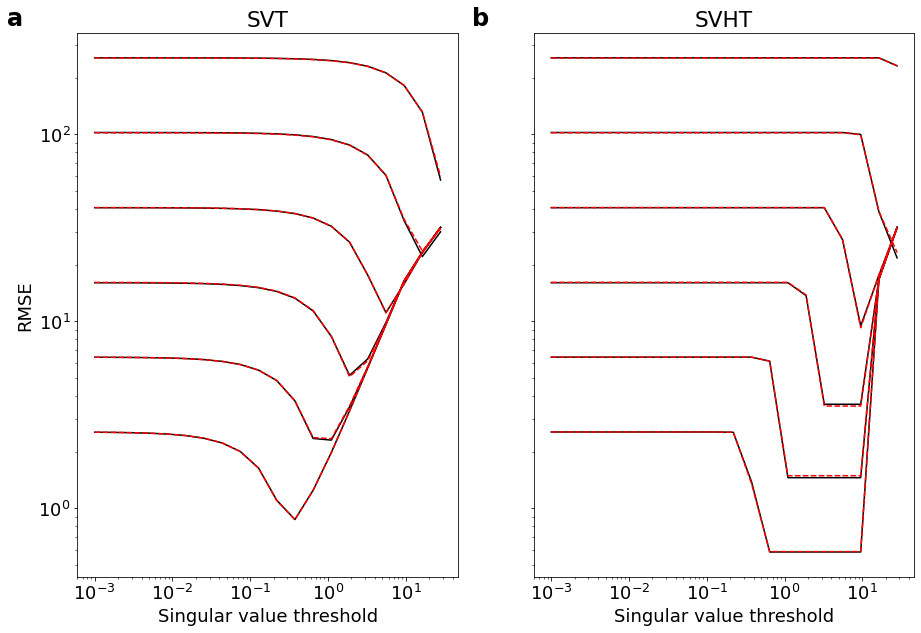

In [118]:
def RMSE(data):
    return np.linalg.norm(data-noiseless)

mse_svt = []
mse_svht = []
sure_svt = []
sure_svht = []
for data, sd in zip(noisy_data, sd_noisy):
    # Calculate MSE by denoising
    tmp_mse_svt = []
    tmp_mse_svht = []
    for th in threshold:
        svt_denoised = svt(data, th)
        tmp_mse_svt.append(RMSE(svt_denoised))
        
        svht_denoised = svht(data, th)
        tmp_mse_svht.append(RMSE(svht_denoised))
    mse_svt.append(tmp_mse_svt)
    mse_svht.append(tmp_mse_svht)
    
    # Calculate the SURE predicted MSE
    current_data = data.reshape(-1, data.shape[-1])
    _, S, _ = lsvd(data.reshape(-1, data.shape[-1]))
    S = np.diag(S)
    tmp_sure_svt = []
    tmp_sure_svht = []
    for th in threshold:
        tmp_sure_svt.append(SURE_SVT(th, S, sd**2, current_data.shape[0], current_data.shape[1]))
        rank = np.sum(S>th)
        tmp_sure_svht.append(SURE_SVHT(rank, S[::-1], sd**2, current_data.shape[0], current_data.shape[1]))
    sure_svt.append(tmp_sure_svt)
    sure_svht.append(tmp_sure_svht)
    
mse_svt= np.asarray(mse_svt)
mse_svht= np.asarray(mse_svht)
sure_svt= np.asarray(sure_svt)
sure_svht= np.asarray(sure_svht)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10), sharey=True)
ax1.loglog(threshold,mse_svt.T, 'k')
ax1.loglog(threshold,np.sqrt(sure_svt.T),'r--')
ax1.set_title('SVT')
ax1.set_ylabel('RMSE')
ax1.set_xlabel('Singular value threshold')

ax2.loglog(threshold,mse_svht.T, 'k')
ax2.loglog(threshold,np.sqrt(sure_svht.T),'r--')
ax2.set_title('SVHT')
ax2.set_xlabel('Singular value threshold')

fig.text(0.06, 0.89,'a',fontweight='bold',fontsize=24)
fig.text(0.49, 0.89,'b',fontweight='bold',fontsize=24)
plt.savefig('figures/supp_fig_SURE.png', bbox_inches='tight', dpi=300)
# plt.show()